## Introduction to the Code

This code is designed to analyze the impact of a retail trial on store performance by comparing a trial store (where the trial was conducted) with a control store (a similar store not part of the trial). The analysis focuses on key metrics such as total sales and number of customers to determine whether the trial had a statistically significant effect.
Key Objectives:

   * Select a Control Store:

       * Identify a control store that closely matches the trial store in terms of pre-trial performance (e.g., sales, customer count).

       * Use correlation and magnitude distance to quantify the similarity between stores.

   * Visualize Trends:

       * Compare the performance of the trial store, control store, and other stores over time.

       * Visualize trends in total sales and number of customers during the pre-trial and trial periods.

   * Assess Trial Impact:

      * Scale the control store's performance to match the trial store's pre-trial performance.

      * Calculate the percentage difference between the trial store and the scaled control store during the trial period.

      * Use t-values and confidence intervals to determine if the trial had a statistically significant impact.

**Key Steps in the Code:**

   * Data Preparation:

       * Load the dataset and preprocess it by adding a YEARMONTH column for time-based analysis.

       * Calculate key metrics (e.g., total sales, number of customers) for each store and month.

   * Control Store Selection:

       * Filter stores with complete pre-trial data.

       * Calculate correlation and magnitude distance to identify the most similar control store.

   * Trend Visualization:

       * Plot trends in total sales and number of customers for the trial store, control store, and other stores.

   * Trial Impact Analysis:

       * Scale the control store's performance to match the trial store's pre-trial performance.

       * Calculate the percentage difference between the trial store and the scaled control store.

       * Assess statistical significance using t-values and confidence intervals.

**Why This Analysis Matters:**

   * Business Decision-Making:

        * Helps determine whether the trial had a positive, negative, or neutral impact on store performance.

        * Provides insights into whether the trial should be rolled out to other stores or discontinued.

   * Statistical Rigor:

       * Uses robust statistical methods (e.g., correlation, magnitude distance, t-tests) to ensure reliable results.

       * Visualizations make it easy to interpret trends and results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/kaggle/input/qvi-retail-data-comprehensive-insights-task-2/QVI_data.csv')

# Display the first few rows of the dataset
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Create YEARMONTH Column

In [3]:
# Convert the DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Create a new column YEARMONTH in the format yyyymm
data['YEARMONTH'] = data['DATE'].dt.to_period('M').astype(str).str.replace('-', '').astype(int)

# Display the first few rows to verify
print(data[['DATE', 'YEARMONTH']].head())

        DATE  YEARMONTH
0 2018-10-17     201810
1 2018-09-16     201809
2 2019-03-07     201903
3 2019-03-08     201903
4 2018-11-02     201811


## Calculate Matrics

In [4]:
# Group by STORE_NBR and YEARMONTH to calculate metrics
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),  # Total sales
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),  # Number of unique customers
    nTxnPerCust=('TXN_ID', 'count'),  # Number of transactions per customer
    nChipsPerTxn=('PROD_QTY', 'sum'),  # Total chips sold per transaction
    avgPricePerUnit=('TOT_SALES', 'mean')  # Average price per unit
).reset_index()

# Display the first few rows
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,3.978846
1,1,201808,176.1,42,43,54,4.095349
2,1,201809,278.8,59,62,75,4.496774
3,1,201810,188.1,44,45,58,4.180000
4,1,201811,192.6,46,47,57,4.097872


In [5]:
# Filter stores with full observation periods (12 months)
storesWithFullObs = measureOverTime.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

# Filter to the pre-trial period (before February 2019)
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & 
                                   (measureOverTime['STORE_NBR'].isin(storesWithFullObs))]

# Display the first few rows
preTrialMeasures.head()


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,3.978846
1,1,201808,176.1,42,43,54,4.095349
2,1,201809,278.8,59,62,75,4.496774
3,1,201810,188.1,44,45,58,4.180000
4,1,201811,192.6,46,47,57,4.097872


## Function to Calculate Correlation

In [6]:
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    store_numbers = input_table['STORE_NBR'].unique()
    
    for i in store_numbers:
        if i != store_comparison:
            corr_measure = input_table[input_table['STORE_NBR'] == store_comparison][metric_col].corr(
                input_table[input_table['STORE_NBR'] == i][metric_col]
            )
            new_row = pd.DataFrame({
                'Store1': [store_comparison],
                'Store2': [i],
                'corr_measure': [corr_measure]
            })
            calc_corr_table = pd.concat([calc_corr_table, new_row], ignore_index=True)
    
    return calc_corr_table

## Function to Calculate Magnitude Distance

In [7]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    # Initialize calc_dist_table with the correct dtypes
    calc_dist_table = pd.DataFrame({
        'Store1': pd.Series(dtype='int64'),
        'Store2': pd.Series(dtype='int64'),
        'YEARMONTH': pd.Series(dtype='int64'),
        'measure': pd.Series(dtype='float64')
    })
    
    store_numbers = input_table['STORE_NBR'].unique()
    
    for i in store_numbers:
        if i != store_comparison:
            # Calculate the absolute difference for each month
            store_comparison_data = input_table[input_table['STORE_NBR'] == store_comparison]
            store_i_data = input_table[input_table['STORE_NBR'] == i]
            merged_data = pd.merge(store_comparison_data, store_i_data, on='YEARMONTH', suffixes=('_trial', '_control'))
            
            measure = abs(merged_data[f'{metric_col}_trial'] - merged_data[f'{metric_col}_control'])
            
            new_row = pd.DataFrame({
                'Store1': [store_comparison] * len(measure),
                'Store2': [i] * len(measure),
                'YEARMONTH': merged_data['YEARMONTH'],
                'measure': measure
            })
            calc_dist_table = pd.concat([calc_dist_table, new_row], ignore_index=True)
    
    # Standardize the magnitude distance
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH']).agg(
        minDist=('measure', 'min'),
        maxDist=('measure', 'max')
    ).reset_index()
    
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])
    
    final_dist_table = dist_table.groupby(['Store1', 'Store2']).agg(
        mag_measure=('magnitudeMeasure', 'mean')
    ).reset_index()
    
    return final_dist_table

## Use Functions to Calculate Metrics

This task involves using the functions to calculate correlation and magnitude distance for total sales and number of customers.

In [8]:
# Calculate correlation and magnitude for total sales and number of customers
trial_store = 86
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

# Display the results
print("Correlation for Sales:\n", corr_nSales.head())
print("Magnitude for Sales:\n", magnitude_nSales.head())

Correlation for Sales:
   Store1 Store2 corr_measure
0     86      1          NaN
1     86      2          NaN
2     86      3          NaN
3     86      4          NaN
4     86      5          NaN
Magnitude for Sales:
    Store1  Store2  mag_measure
0      86       1     0.220565
1      86       2     0.179640
2      86       3     0.762894
3      86       4     0.498526
4      86       5     0.929321


In [9]:
# Combine correlation and magnitude scores
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']

# Combine scores across the drivers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# Ensure 'finalControlScore' is numeric
score_Control['finalControlScore'] = pd.to_numeric(score_Control['finalControlScore'], errors='coerce')

# Select control store based on the highest score
control_store = score_Control[score_Control['Store1'] == trial_store].nlargest(1, 'finalControlScore')['Store2'].values[0]
print("Control Store for Trial Store 77:", control_store)

Control Store for Trial Store 77: 1


## Visualize Total Sales Trends

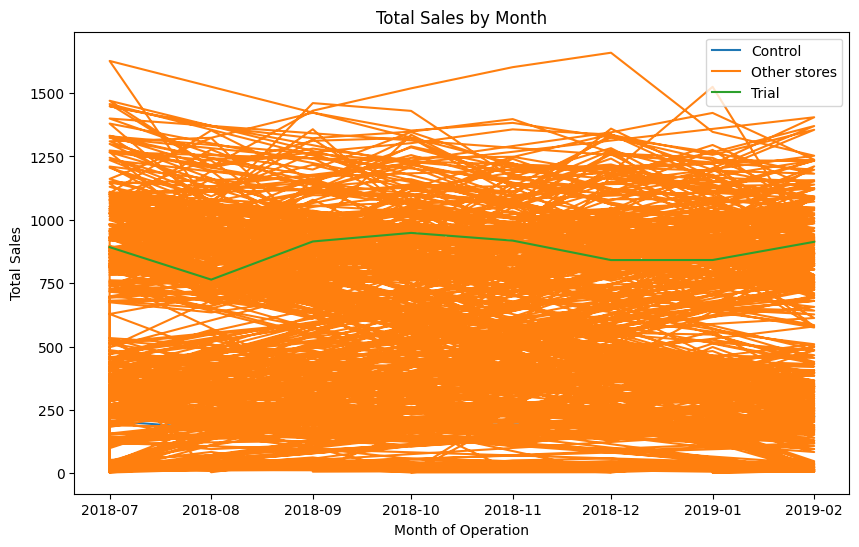

In [16]:
# Create a copy of measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()

# Add a Store_type column to classify stores as Trial, Control, or Other
measureOverTimeSales['Store_type'] = np.where(
    measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Filter to the pre-trial period (before March 2019)
pastSales = measureOverTimeSales[measureOverTimeSales['YEARMONTH'] < 201903].copy()  # ✅ Added `.copy()`

# Convert YEARMONTH to a datetime format for plotting
pastSales.loc[:, 'TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Plot total sales by month
plt.figure(figsize=(10, 6))
for store_type, group in pastSales.groupby('Store_type'):
    plt.plot(group['TransactionMonth'], group['totSales'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend()
plt.show()


## Visualize Customer Count Trends

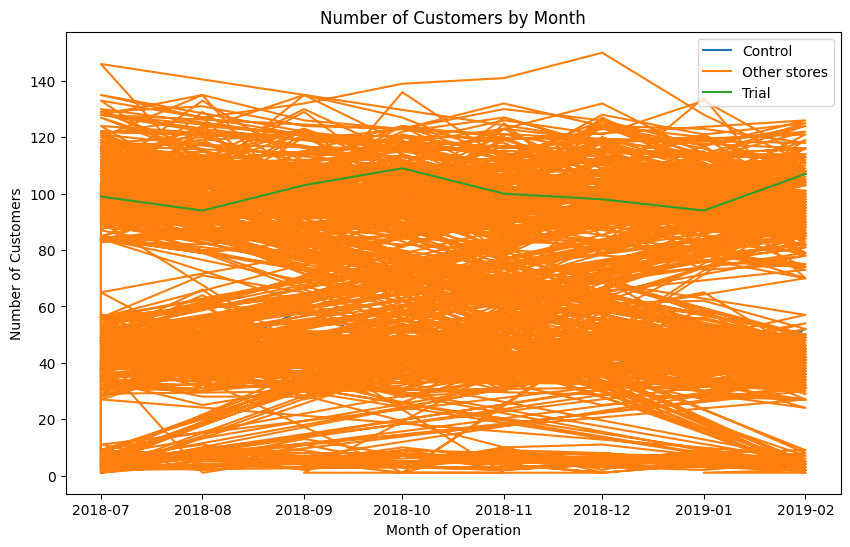

In [11]:
# Create a copy of measureOverTime for visualization
measureOverTimeCusts = measureOverTime.copy()

# Add a Store_type column to classify stores as Trial, Control, or Other
measureOverTimeCusts['Store_type'] = np.where(
    measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
    np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Filter to the pre-trial period (before March 2019)
pastCustomers = measureOverTimeCusts[measureOverTimeCusts['YEARMONTH'] < 201903].copy()  # ✅ Added `.copy()`

# Convert YEARMONTH to a datetime format for plotting
pastCustomers.loc[:, 'TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Plot number of customers by month
plt.figure(figsize=(10, 6))
for store_type, group in pastCustomers.groupby('Store_type'):
    plt.plot(group['TransactionMonth'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend()
plt.show()


## Scale Control Store Sales

In [12]:
# Calculate scaling factor for control store sales
scalingFactorForControlSales = preTrialMeasures[
    (preTrialMeasures['STORE_NBR'] == trial_store) & 
    (preTrialMeasures['YEARMONTH'] < 201902)
]['totSales'].sum() / preTrialMeasures[
    (preTrialMeasures['STORE_NBR'] == control_store) & 
    (preTrialMeasures['YEARMONTH'] < 201902)
]['totSales'].sum()

# Apply the scaling factor to control store sales
scaledControlSales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

# Display the scaled control sales
print(scaledControlSales.head())

   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1     201807     206.9          49           52            62   
1          1     201808     176.1          42           43            54   
2          1     201809     278.8          59           62            75   
3          1     201810     188.1          44           45            58   
4          1     201811     192.6          46           47            57   

   avgPricePerUnit Store_type  controlSales  
0         3.978846    Control    912.969187  
1         4.095349    Control    777.060772  
2         4.496774    Control   1230.235907  
3         4.180000    Control    830.012103  
4         4.097872    Control    849.868851  


## Calculate Percentage Difference
Explanation:

    
* The scaling factor is calculated as the ratio of the trial store's pre-trial sales to the control store's pre-trial sales.
* The control store's sales are scaled using this factor.
* The percentage difference between the trial store's sales and the scaled control store's sales is calculated.


In [13]:
# Merge trial store sales and scaled control store sales
percentageDiff = pd.merge(
    scaledControlSales[['YEARMONTH', 'controlSales']],
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']],
    on='YEARMONTH'
)

# Calculate the percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Display the percentage difference
print(percentageDiff.head())

   YEARMONTH  controlSales  totSales  percentageDiff
0     201807    912.969187    892.20        0.022749
1     201808    777.060772    764.05        0.016744
2     201809   1230.235907    914.60        0.256565
3     201810    830.012103    948.40        0.142634
4     201811    849.868851    918.00        0.080167



## Calculate t-Values

In [14]:
# Calculate the standard deviation of percentage differences during the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom (8 months in pre-trial period)
degreesOfFreedom = 7

# Calculate t-values for the trial months
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Display the t-values
print(percentageDiff[['YEARMONTH', 'tValue']])

    YEARMONTH    tValue
0      201807  0.217765
1      201808  0.160278
2      201809  2.455968
3      201810  1.365361
4      201811  0.767394
5      201812  0.052277
6      201901  2.218786
7      201902  0.783453
8      201903  1.974875
9      201904  0.033655
10     201905  0.858842
11     201906  0.869290


## Visualize Results 
Explanation:

   
*  The standard deviation of percentage differences during the pre-trial period is calculated.
*  The t-values are calculated for the trial months to assess statistical significance.
*  The results are visualized, showing the trial store's sales, control store's sales, and the 95% confidence interval.


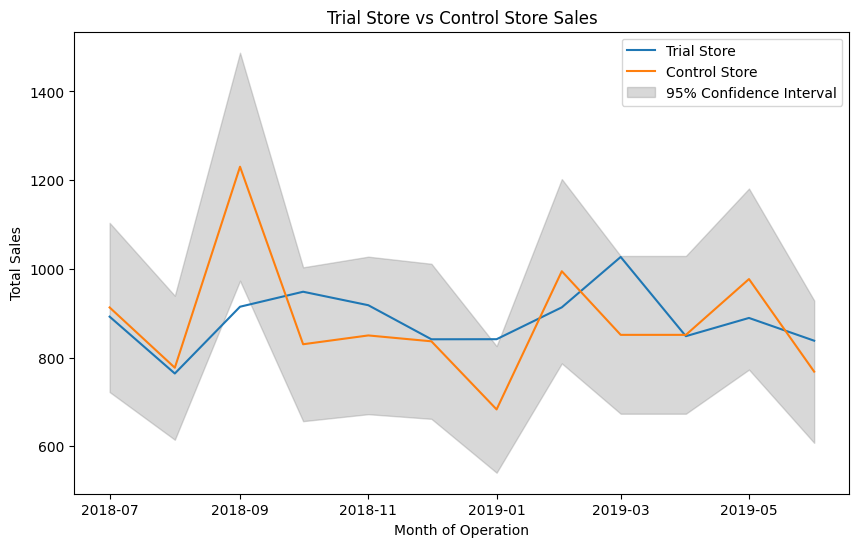

In [15]:
# Convert YEARMONTH to a datetime format for plotting
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')

# Plot trial store sales, control store sales, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(percentageDiff['TransactionMonth'], percentageDiff['totSales'], label='Trial Store')
plt.plot(percentageDiff['TransactionMonth'], percentageDiff['controlSales'], label='Control Store')

# Add 95th percentile confidence interval
plt.fill_between(
    percentageDiff['TransactionMonth'],
    percentageDiff['controlSales'] * (1 - 2 * stdDev),
    percentageDiff['controlSales'] * (1 + 2 * stdDev),
    color='gray', alpha=0.3, label='95% Confidence Interval'
)

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Trial Store vs Control Store Sales')
plt.legend()
plt.show()

## Repeat for Other Trial Stores

The process for trial stores 86 and 88 is identical to the one for trial store 77. You can reuse the same functions and steps, replacing trial_store = 77 with trial_store = 86 or trial_store = 88.